In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00a 0:00:01


In [3]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 17.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 20.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [4]:
from torch_geometric.datasets import Amazon
import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

# Cargue de datos

In [5]:
# Carga del dataset Amazon Computers
dataset = Amazon(root='path/to/data', name='Computers')

In [6]:
data = dataset[0]

# Análisis de datos

## Características del grafo

In [7]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of edges: {data.edge_index.shape[1]}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: AmazonComputers()
---------------
Number of graphs: 1
Number of nodes: 13752
Number of features: 767
Number of classes: 10
Number of edges: 491722

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


Se identifica que se cuenta con 13752 nodos y 491722 aristas que los unen. Adicionalmente, el dataset ya cuenta con un embedding (bag-of-words), según se describe en la página web https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Amazon.html#torch_geometric.datasets.Amazon, el cual cuenta con una dimensión de 767 características.

## Clases de los nodos

En relación con las clases de los nodos, se realiza su correspondiente gráfico de barras:

In [8]:
unique, counts = torch.unique(data.y, return_counts=True)

df_distribution = pd.DataFrame(dict(zip(unique.tolist(), counts.tolist())), index=['Cantidad']).T
df_distribution.index.name = 'Etiqueta'
print(df_distribution.T)

Etiqueta    0     1     2    3     4    5    6    7     8    9
Cantidad  436  2142  1414  542  5158  308  487  818  2156  291


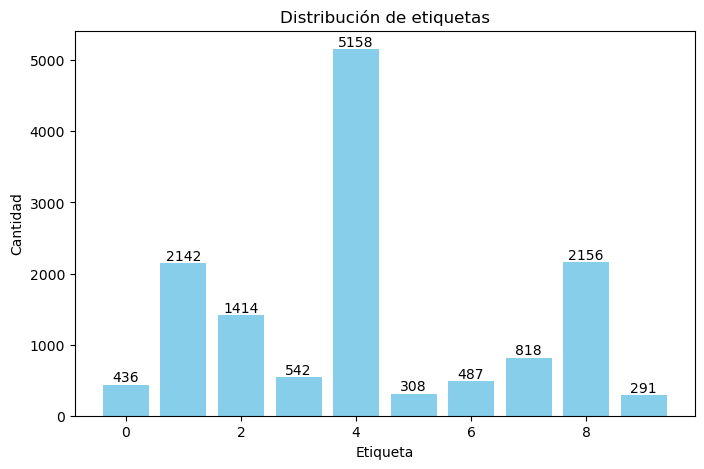

In [9]:
plt.figure(figsize=(8, 5))
bars = plt.bar(df_distribution.index, df_distribution['Cantidad'], color='skyblue')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad')
plt.title('Distribución de etiquetas')
plt.xticks(rotation=0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

plt.show()

## Visualización del grafo

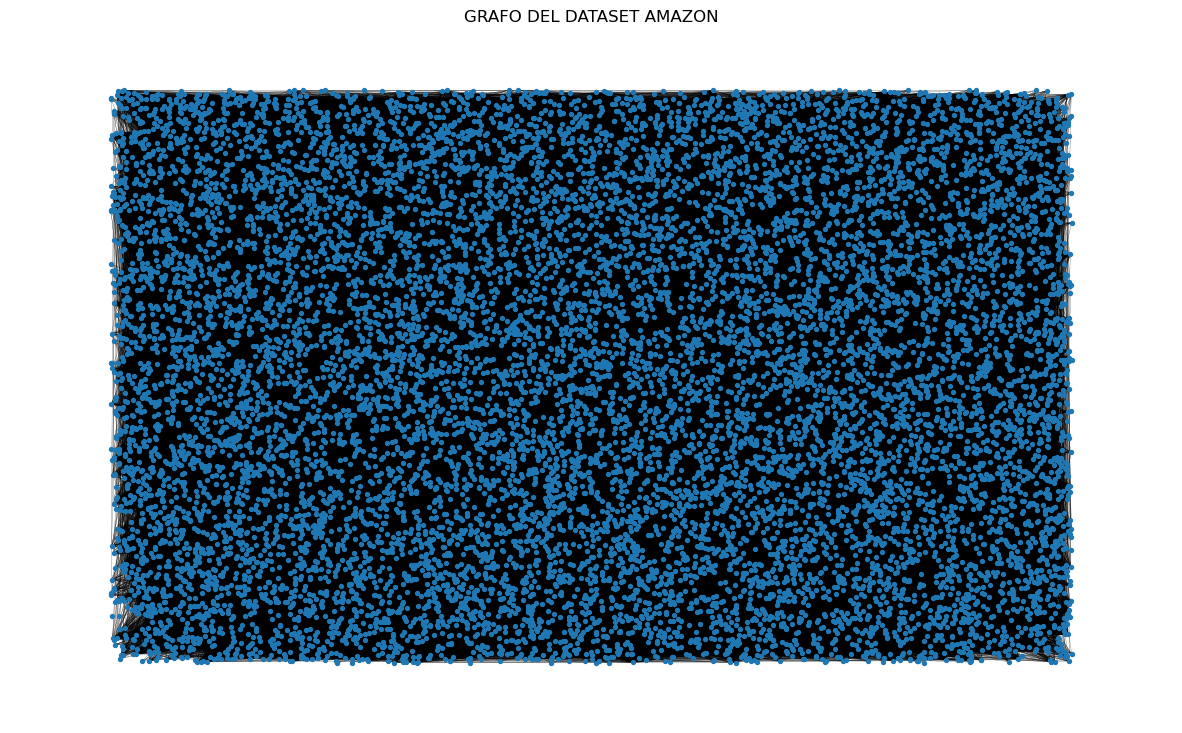

In [9]:
G = nx.Graph()

for i in range(data.num_nodes):
    G.add_node(i, label=data.y[i].item())

edge_index = data.edge_index.numpy()
for edge in edge_index.T:
    G.add_edge(edge[0], edge[1])

fig, ax = plt.subplots(figsize=(15, 9))
plt.axis('off')
plot_options = {"node_size": 8, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)
plt.title("GRAFO DEL DATASET AMAZON")
plt.show()

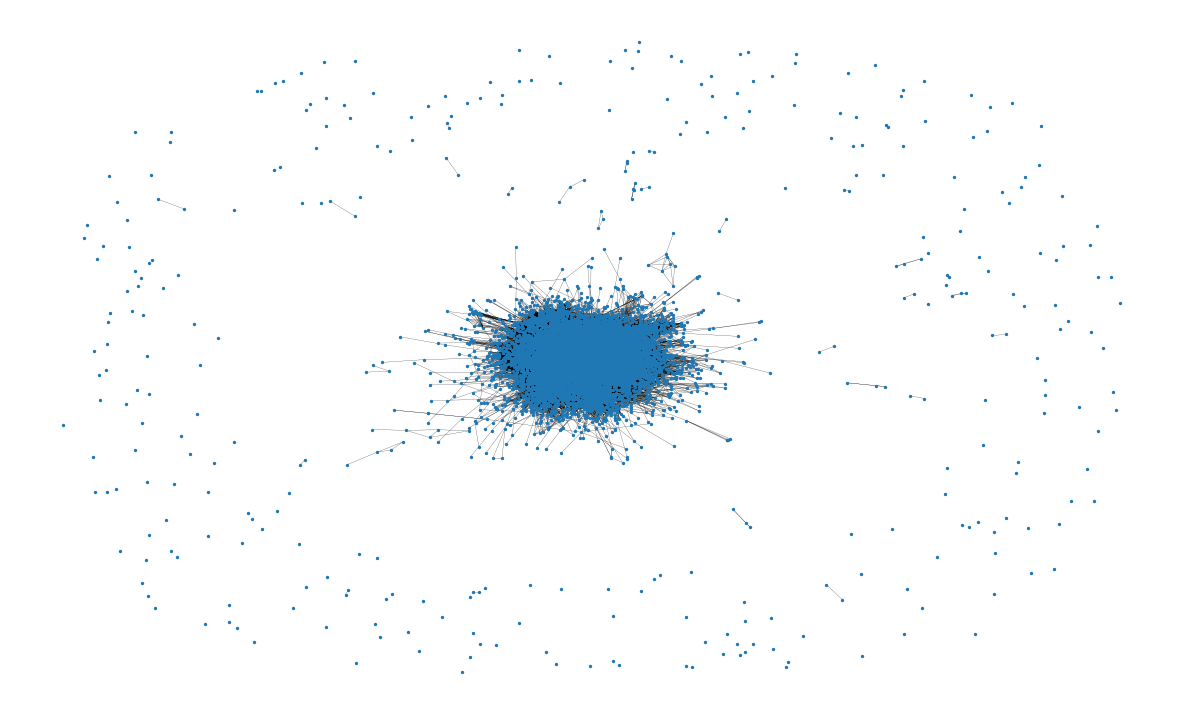

In [11]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 2, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

## Métricas

Número de grados promedio

In [10]:
np.mean([d for _, d in G.degree()])

35.7563990692263

In [112]:
np.median([d for _, d in G.degree()])

22.0

In [113]:
np.max([d for _, d in G.degree()])

2992

### Métricas de integración

* Camino más corto

In [11]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

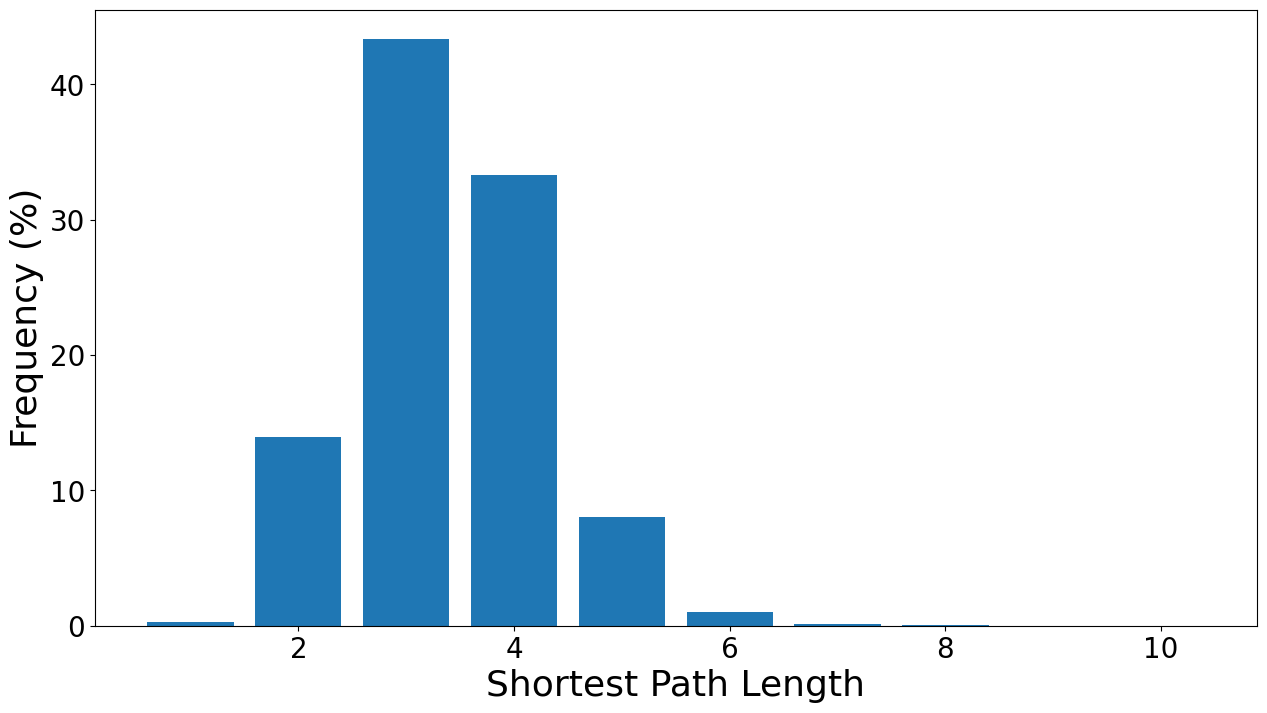

In [12]:
path_lengths = np.zeros(11, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, 11), height=freq_percent)
#ax.set_title(
#    "Distribution of shortest path length in G", fontdict={"size": 35}, loc="center"
#)
ax.set_xlabel("Shortest Path Length", fontdict={"size": 26})
ax.set_ylabel("Frequency (%)", fontdict={"size": 26})

ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)

plt.show()

In [67]:
pd.DataFrame(freq_percent).T

,0,1,2,3,4,5,6,7,8,9
0,0.274647,13.917654,43.354117,33.278559,8.048354,0.984678,0.122825,0.018007,0.001098,0.00006


* Camino más corto promedio

In [15]:
average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
np.mean(average_path_lengths)

3.2981462629421725

* Eficiencia global

In [16]:
nx.is_connected(G)

False

In [17]:
nx.density(G)

0.0026002762758509414

In [18]:
def eficiencia_global(shortest_path_lengths):
    eficiencia = 0
    N = len(shortest_path_lengths)

    for i in shortest_path_lengths:
        for j in shortest_path_lengths[i]:
            if i != j:
                distancia = shortest_path_lengths[i][j]
                eficiencia += 1 / distancia

    return eficiencia / (N * (N - 1))

efficiency = eficiencia_global(shortest_path_lengths)
print(f"Eficiencia global del grafo: {efficiency}")

Eficiencia global del grafo: 0.3010561898856509


### Métricas de centralidad

* Degree Centrality

In [40]:
degree_centrality = nx.centrality.degree_centrality(G)  # save results in a variable to use again
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(12888, 0.217584175696313),
 (8210, 0.18238673551014473),
 (8140, 0.18144134972002038),
 (4528, 0.13453567013308124),
 (1524, 0.11380990473420116),
 (7984, 0.09235691949676388),
 (872, 0.08508472111119192),
 (9915, 0.07570358519380409)]

In [89]:
type(degree_centrality)

dict

In [108]:
percentiles = [0.25,0.50,0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['Centrality']).describe(percentiles=percentiles).T.round(4)

,count,mean,std,min,25%,50%,75%,80%,85%,90%,95%,99%,max
Centrality,13752.0,0.0026,0.0051,0.0,0.0007,0.0016,0.003,0.0034,0.0042,0.0053,0.0073,0.0178,0.2176


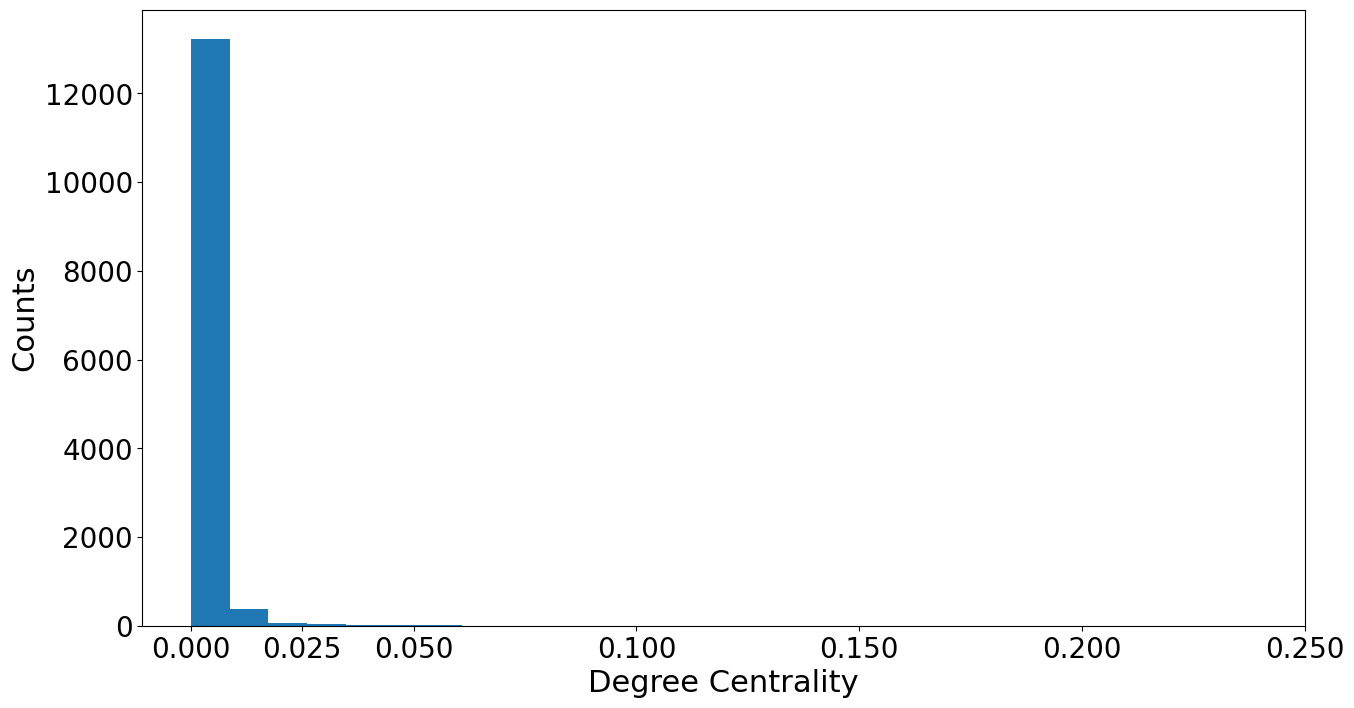

In [60]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25], fontsize=20)
plt.yticks(fontsize=20)
#plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 22})
plt.ylabel("Counts", fontdict={"size": 22})
plt.show()

* Betweenness Centrality

Tomó mucho tiempo para poder calcularlo

In [56]:
betweenness_centrality = nx.centrality.betweenness_centrality(G)
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(8140, 0.13444796532143113),
 (12888, 0.13368570883323128),
 (8210, 0.05500887073613758),
 (6769, 0.05021720964668318),
 (4528, 0.04044688057022516),
 (7742, 0.03203634152958181),
 (12475, 0.026287838176671536),
 (9251, 0.02296840849014709)]

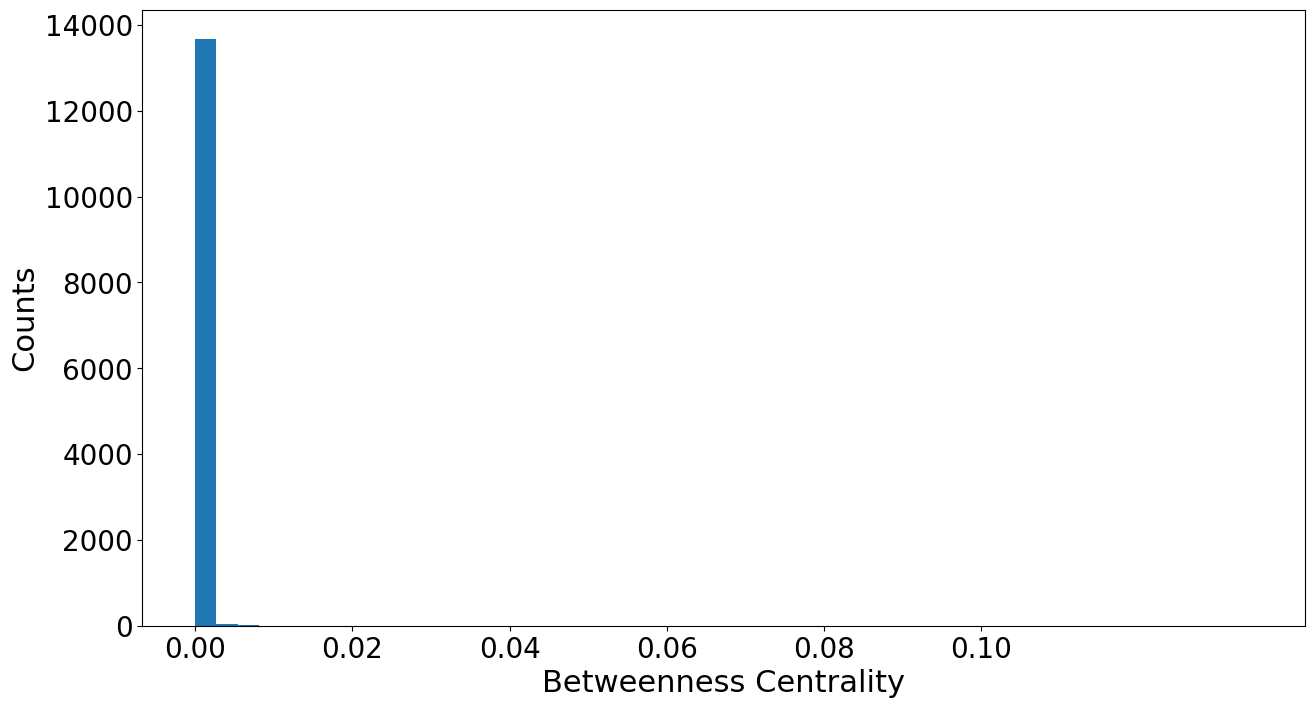

In [61]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=50)
plt.xticks(ticks=[0, 0.02, 0.04, 0.06, 0.08, 0.1], fontsize=20)
plt.yticks(fontsize=20)
#plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 22})
plt.ylabel("Counts", fontdict={"size": 22})
plt.show()

In [109]:
percentiles = [0.25,0.50,0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['Centrality']).describe(percentiles=percentiles).T.round(4)

,count,mean,std,min,25%,50%,75%,80%,85%,90%,95%,99%,max
Centrality,13752.0,0.0002,0.0019,0.0,0.0,0.0,0.0001,0.0001,0.0002,0.0003,0.0005,0.0019,0.1344


In [102]:
np.median(pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['Centrality']))

1.5187393837830192e-05

* Closeness Centrality

In [63]:
closeness_centrality = nx.centrality.closeness_centrality(G)
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(8140, 0.46441727701565605),
 (12888, 0.46440071080045253),
 (4528, 0.4299824799055382),
 (8210, 0.41972433833838046),
 (1524, 0.40999589111859563),
 (9251, 0.40528622876381054),
 (12475, 0.4037778595844024),
 (9915, 0.39261186750844046)]

<function matplotlib.pyplot.show(close=None, block=None)>

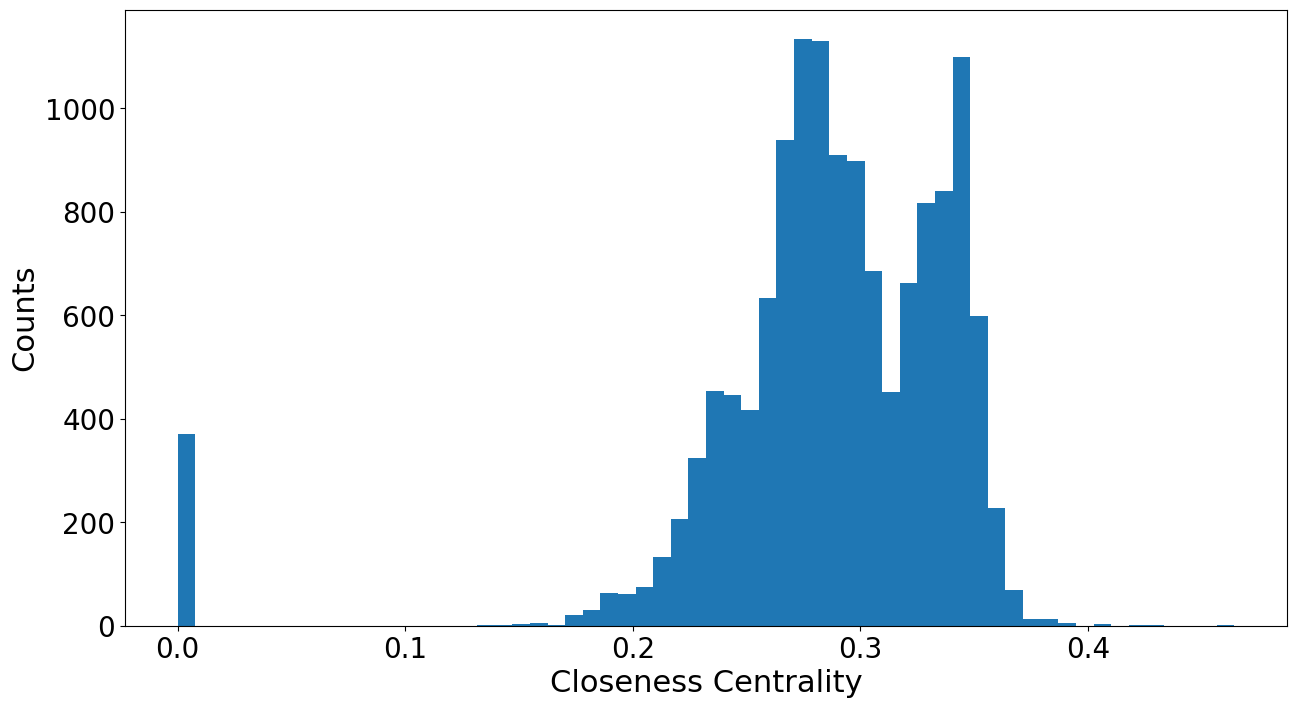

In [64]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
#plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Closeness Centrality", fontdict={"size": 22})
plt.ylabel("Counts", fontdict={"size": 22})
plt.show

In [110]:
percentiles = [0.25,0.50,0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
pd.DataFrame.from_dict(closeness_centrality, orient='index', columns=['Centrality']).describe(percentiles=percentiles).T.round(4)

,count,mean,std,min,25%,50%,75%,80%,85%,90%,95%,99%,max
Centrality,13752.0,0.2855,0.0618,0.0,0.2648,0.2898,0.3278,0.334,0.3403,0.3457,0.3509,0.3627,0.4644


* Eigenvector centrality

In [68]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(G)
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(12888, 0.21079378254756365),
 (8210, 0.1983643405617534),
 (8140, 0.16972885546934052),
 (4528, 0.15874340384394187),
 (1524, 0.1338533964107459),
 (872, 0.12365364759919896),
 (7984, 0.12270840499088667),
 (2138, 0.10445758931862383)]

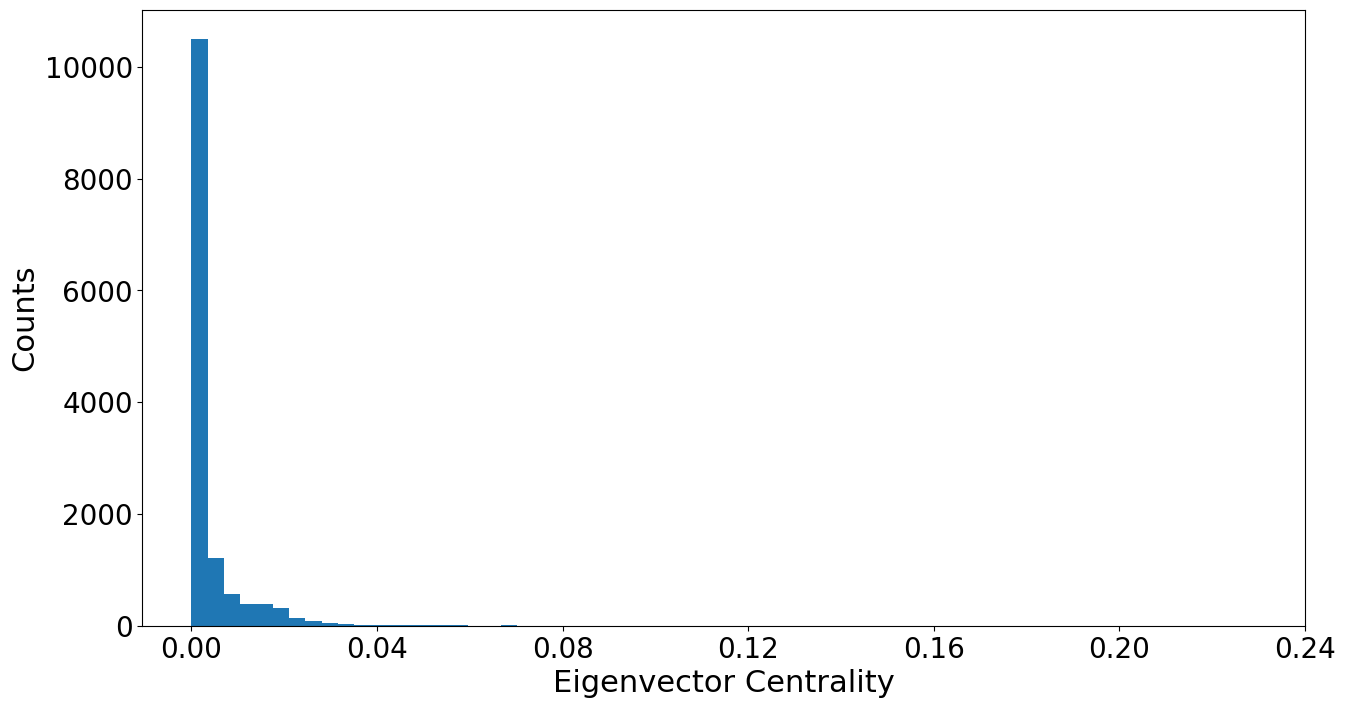

In [67]:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.xticks(ticks=[0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title("Eigenvector Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Eigenvector Centrality", fontdict={"size": 22})
plt.ylabel("Counts", fontdict={"size": 22})
plt.show()

In [111]:
percentiles = [0.25,0.50,0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
pd.DataFrame.from_dict(eigenvector_centrality, orient='index', columns=['Centrality']).describe(percentiles=percentiles).T.round(4)

,count,mean,std,min,25%,50%,75%,80%,85%,90%,95%,99%,max
Centrality,13752.0,0.0034,0.0078,0.0,0.0,0.0003,0.0032,0.0046,0.0069,0.0114,0.0176,0.0303,0.2108


### Métricas de segregación

* Clustering coefficient

In [69]:
nx.average_clustering(G)

0.34412638745332524

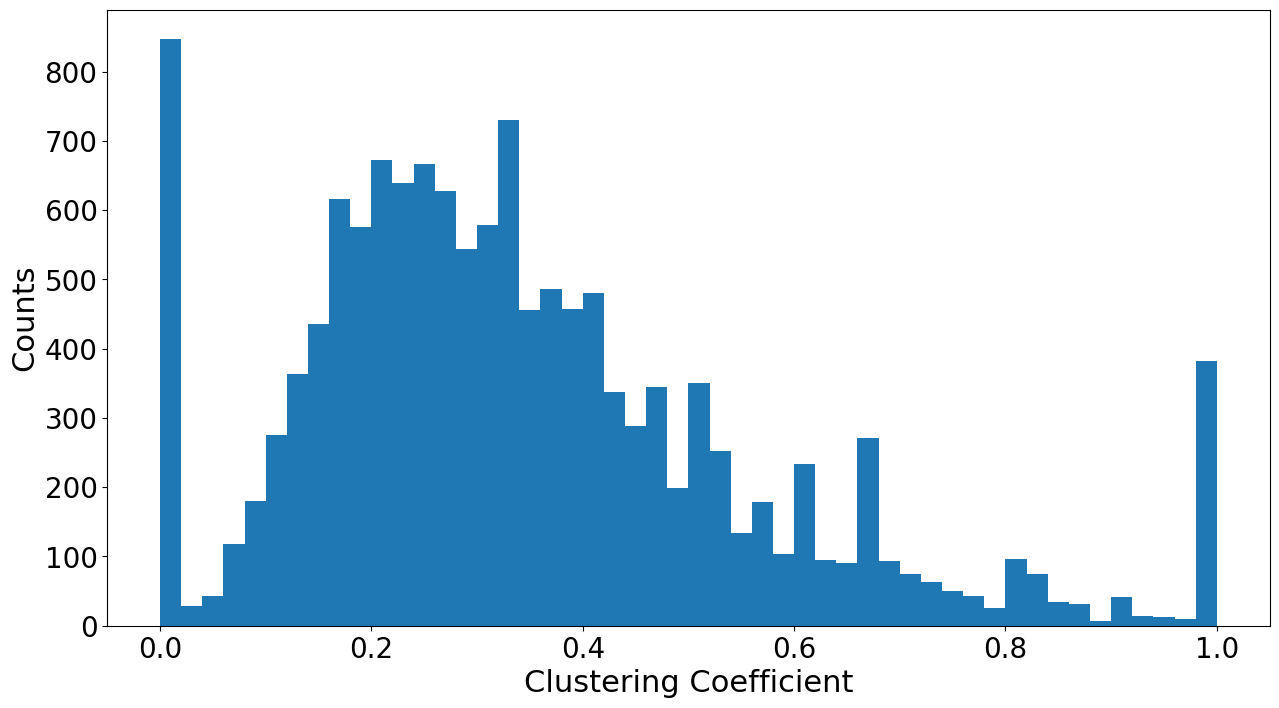

In [72]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50)
#plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 22})
plt.ylabel("Counts", fontdict={"size": 22})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

* Transitividad

In [49]:
triangles_per_node = list(nx.triangles(G).values())
sum(triangles_per_node) / 3

1527469.0

In [50]:
np.mean(triangles_per_node)

333.21749563699825

In [51]:
np.median(triangles_per_node)

69.0

* Bridges

In [52]:
nx.has_bridges(G)

True

In [53]:
bridges = list(nx.bridges(G))
len(bridges)

342

In [54]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

6406

(-1.086241152882576,
 1.0993448168039321,
 -1.0834835946559906,
 1.0895123660564423)

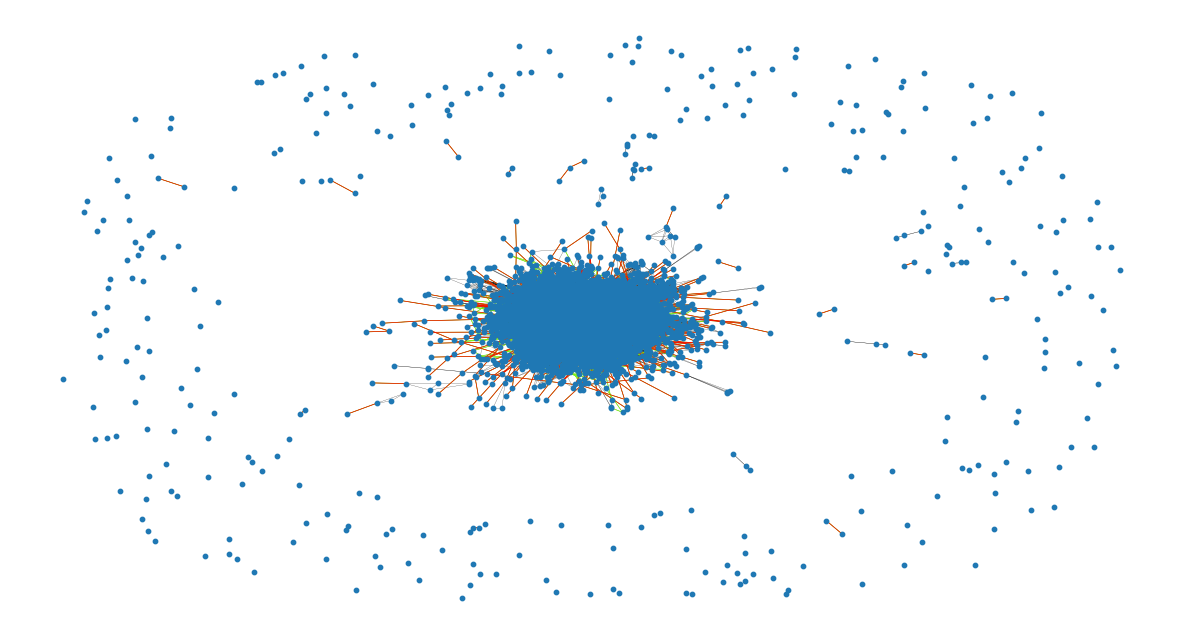

In [55]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # green color for local bridges
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # red color for bridges
plt.axis("off")

* Communities

In [58]:
colors = ["" for x in range(G.number_of_nodes())]  # initialize colors list
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    counter += 1
    for node in list(
        com
    ):  # fill colors list with the particular color for the community nodes
        colors[node] = color
counter

430

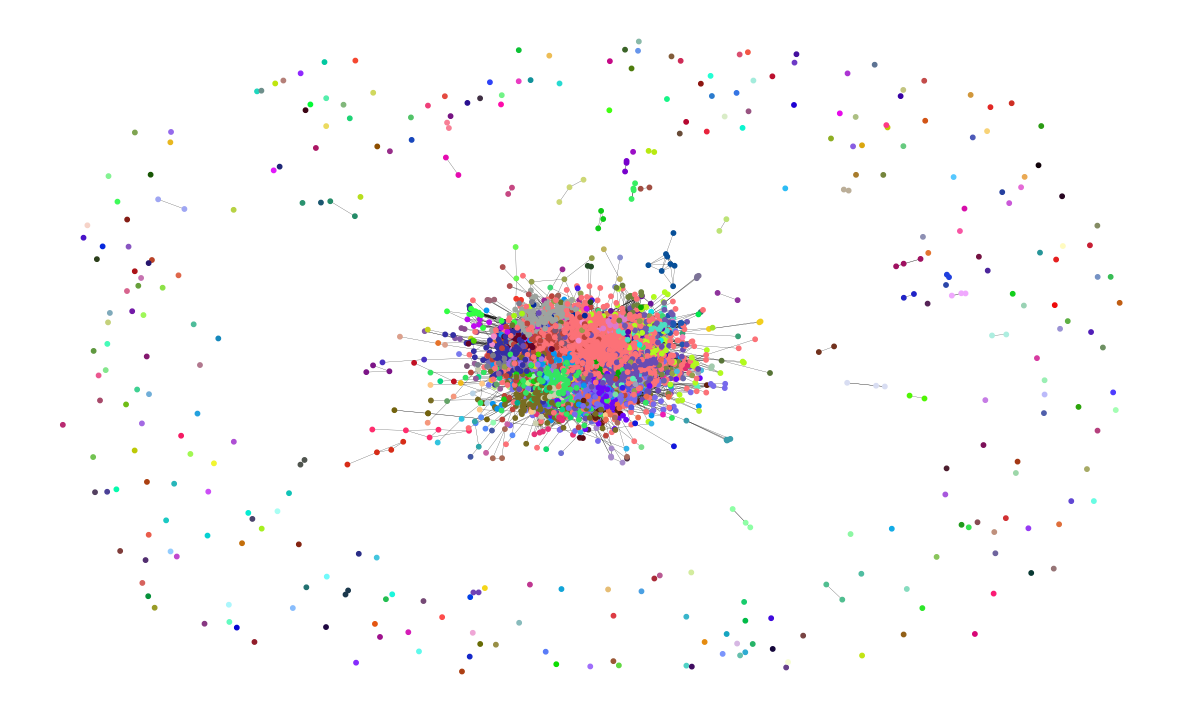

In [60]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors)

### Métricas de resiliencia

* Assortativity

In [56]:
nx.degree_assortativity_coefficient(G)

-0.056487705164197634

In [57]:
nx.degree_pearson_correlation_coefficient(G)

-0.0564877051641818